# Разработка A/B-тестирования и анализ результатов

Вы работаете продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Вас, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработайте с историческими данными приложения:

- Импортируйте библиотеку pandas.

- Считайте и сохраните в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведите на экран первые пять строк полученного датафрейма.

In [1]:
# импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.power import NormalIndPower
from scipy import stats


In [2]:
# сохраняем в датафрейм
sessions_history = pd.read_csv('...')
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитайте количество уникальных сессий `session_id`.

- Выведите на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберите любого из них.

- Изучите таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [3]:
sessions_per_user = sessions_history.groupby('user_id')['session_id'].nunique()
display (sessions_per_user)

user_id
00005FB6A13A6FBE    2
0000B15A18D77ED9    3
0000C4E3A4A571A9    2
000293FAF9E67A81    4
00029C5AE889A6C3    2
                   ..
FFFCDE7746148710    4
FFFDD413285E753F    3
FFFECBA0F2578AB0    2
FFFEDB68228B5F21    5
FFFF4228DF580C3B    3
Name: session_id, Length: 134039, dtype: int64

In [4]:
# Находим пользователя с максимальным количеством сессий
user_with_max_sessions = sessions_per_user.idxmax()
display(user_with_max_sessions)


'10E0DEFC1ABDBBE0'

In [5]:
# Выводим все данные для этого пользователя
user_data = sessions_history[sessions_history['user_id'] == user_with_max_sessions]
display(user_data)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируйте, как менялось число регистраций в приложении за время его существования.

- Агрегируйте исторические данные и рассчитайте число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считайте, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Постройте линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразите их на одном графике.

- Постройте отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

- На обоих графиках должны быть заголовок, подписанные оси X и Y, сетка и легенда.

In [6]:
# Преобразование дат в datetime
sessions_history['session_date'] = pd.to_datetime(sessions_history['session_date'])
sessions_history['install_date'] = pd.to_datetime(sessions_history['install_date'])
display(sessions_history)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android
...,...,...,...,...,...,...,...,...,...,...
435919,769BC199AF26FEF8,914903B51D69C5EA,2025-09-17,2025-09-17 21:33:57,2025-09-04,3,1,3,CIS,PC
435920,599DED39F3CD2ADE,66ADBE343C94DCDA,2025-09-17,2025-09-17 17:11:46,2025-09-04,4,0,4,MENA,iPhone
435921,1FA20C4BC94E64B2,C4CCD7E81733665F,2025-09-17,2025-09-17 19:36:55,2025-09-04,4,0,4,CIS,Android
435922,88E5FC3016A7A0AD,6834FB4914B56200,2025-09-17,2025-09-17 22:13:33,2025-09-04,5,0,4,MENA,PC


In [7]:
# рассчитаем число уникальных и зарегистрированных пользователей для каждого дня
sessions_history_agg = sessions_history.groupby('session_date').agg(
    total_users=('user_id', 'nunique'),
    registered_users=('registration_flag', lambda x: sessions_history.loc[x.index, 'user_id'][x == 1].nunique())
).reset_index()
sessions_history_agg

,session_date,total_users,registered_users
0,2025-08-11,3919,169
1,2025-08-12,6056,336
2,2025-08-13,8489,464
3,2025-08-14,10321,625
4,2025-08-15,14065,840
5,2025-08-16,12205,916
6,2025-08-17,11200,833
7,2025-08-18,10839,860
8,2025-08-19,12118,831
9,2025-08-20,13514,1008


In [8]:
import matplotlib.pyplot as plt

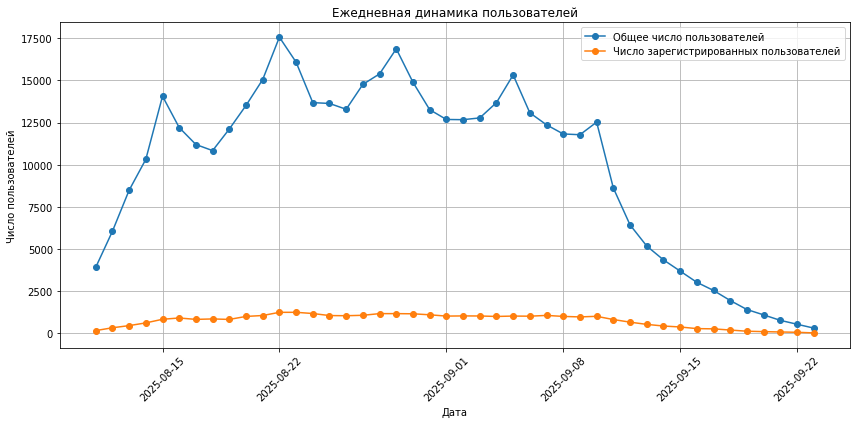

In [9]:
# Первый график: Общее число пользователей и число зарегистрированных пользователей
plt.figure(figsize=(12, 6)) # Установим размер графика
plt.plot(sessions_history_agg['session_date'], sessions_history_agg['total_users'], label='Общее число пользователей', marker='o')
plt.plot(sessions_history_agg['session_date'], sessions_history_agg['registered_users'], label='Число зарегистрированных пользователей', marker='o')
plt.xlabel('Дата')
plt.ylabel('Число пользователей')
plt.title('Ежедневная динамика пользователей')
plt.grid(True) # Добавляем сетку
plt.legend() # Показываем легенду
plt.xticks(rotation=45) # Поворачиваем подписи оси X для читаемости
plt.tight_layout() # Автоматически корректируем параметры подграфиков, чтобы график поместился в область.
plt.show()

In [10]:
# рассчитаем долю зарегистрированных пользователей
sessions_history_agg['share_registered_users'] = sessions_history_agg['registered_users']/sessions_history_agg['total_users']
display(sessions_history_agg['share_registered_users'])

0     0.043123
1     0.055482
2     0.054659
3     0.060556
4     0.059723
5     0.075051
6     0.074375
7     0.079343
8     0.068576
9     0.074589
10    0.070627
11    0.071229
12    0.077913
13    0.086311
14    0.077741
15    0.079013
16    0.072870
17    0.076358
18    0.069579
19    0.078235
20    0.083296
21    0.081041
22    0.081992
23    0.081005
24    0.073595
25    0.067215
26    0.078223
27    0.086440
28    0.085320
29    0.083192
30    0.081031
31    0.095558
32    0.103947
33    0.103608
34    0.100825
35    0.103569
36    0.094327
37    0.106750
38    0.102971
39    0.093089
40    0.097273
41    0.112113
42    0.124542
43    0.100946
Name: share_registered_users, dtype: float64

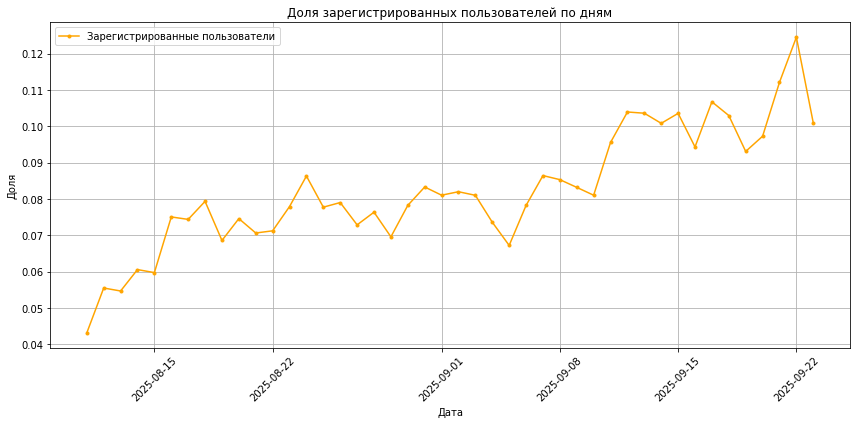

In [11]:
# визуализируем данные
plt.figure(figsize=(12, 6))
plt.plot(sessions_history_agg['session_date'], sessions_history_agg['share_registered_users'], label='Зарегистрированные пользователи', marker='.', color='orange')


plt.title('Доля зарегистрированных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Доля')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы на то, что он зарегистрируется и оплатит подписку.

- Найдите количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29160 сессиях, две страницы в 105536 сессиях и так далее.

- Постройте столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

- На диаграмме должны быть заголовок, подписанные оси X и Y.

In [12]:
session_counts = sessions_history.groupby('page_counter')['session_id'].nunique().reset_index()


# Выводим результат
print(session_counts)

   page_counter  session_id
0             1       29160
1             2      105536
2             3      166690
3             4      105569
4             5       26288
5             6        2589
6             7          92


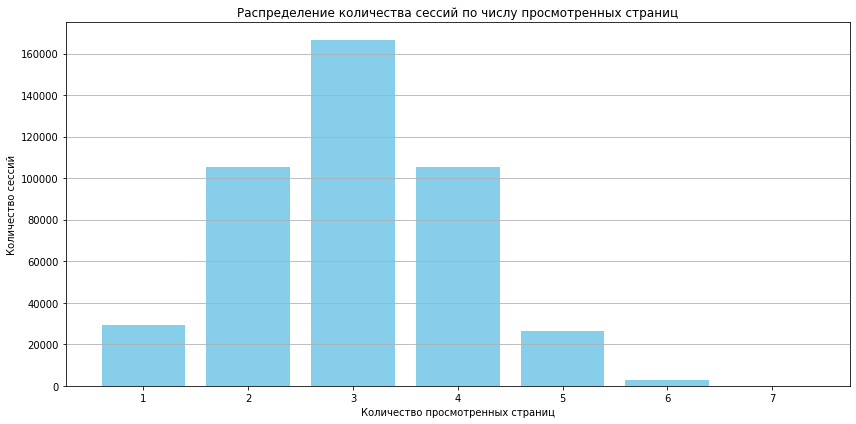

In [13]:
plt.figure(figsize=(12, 6))  # Устанавливаем размер фигуры для лучшей читаемости
plt.bar(session_counts['page_counter'], session_counts['session_id'], color='skyblue')  # Строим столбцы
plt.xlabel('Количество просмотренных страниц')  # Подписываем ось X
plt.ylabel('Количество сессий')  # Подписываем ось Y
plt.title('Распределение количества сессий по числу просмотренных страниц')  # Добавляем заголовок
plt.grid(axis='y') 
plt.xticks(session_counts['page_counter']) 
plt.tight_layout() 
plt.show()  

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Постройте график со средним значением доли успешных сессий ко всем сессиям по дням за весь период наблюдения.

In [14]:
sessions_history = pd.read_csv('/datasets/sessions_project_history.csv')

# Создаем столбец good_session (1 если page_counter >= 4, иначе 0)
sessions_history['good_session'] = (sessions_history['page_counter'] >= 4).astype(int)

# Выводим первые строки и распределение good_session
print(sessions_history.head())
print(sessions_history['good_session'].value_counts())

            user_id        session_id session_date     session_start_ts  \
0  E302123B7000BFE4  F9AF61A0C2023832   2025-08-15  2025-08-15 17:47:35   
1  2530F72E221829FB  85003A206CBDAC6F   2025-08-15  2025-08-15 16:42:14   
2  876E020A4FC512F5  3677423E49D72DEE   2025-08-15  2025-08-15 12:30:00   
3  2640B349E1D81584  956B45F5915CA225   2025-08-15  2025-08-15 15:31:31   
4  94E1CBFAEF1F5EE9  83BF0DA35F9F1F40   2025-08-15  2025-08-15 21:33:53   

  install_date  session_number  registration_flag  page_counter region  \
0   2025-08-15               1                  0             3    CIS   
1   2025-08-15               1                  0             4   MENA   
2   2025-08-15               1                  0             4     EU   
3   2025-08-15               1                  0             4    CIS   
4   2025-08-15               1                  0             3    CIS   

    device  good_session  
0   iPhone             0  
1  Android             1  
2       PC             

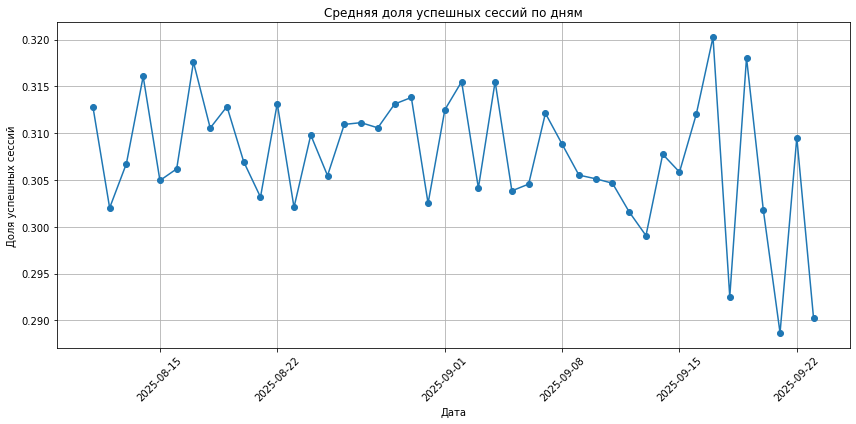

In [15]:
# Построение графика доли успешных сессий по дням

# Преобразуем столбец start_ts в datetime, если он еще не в этом формате
sessions_history['session_start_ts'] = pd.to_datetime(sessions_history['session_start_ts'])

# Создаем столбец с датой
sessions_history['session_date'] = sessions_history['session_start_ts'].dt.date

# Вычисляем долю успешных сессий для каждого дня
daily_success_rate = sessions_history.groupby('session_date')['good_session'].mean()

# Строим график
plt.figure(figsize=(12, 6))
daily_success_rate.plot(kind='line', marker='o')
plt.title('Средняя доля успешных сессий по дням')
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика, рассчитать необходимую длительность проведения теста.

#### 2.1. Расчёт размера выборки
В рамках курса вам уже приходилось рассчитывать размеры выборки, используя онлайн-калькуляторы. В этом задании предлагаем воспользоваться готовым кодом и рассчитать необходимое для вашего дизайна эксперимента количество пользователей.

Для этого установите в коде ниже следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки мы будем использовать метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

Запустите ячейку и изучите полученное значение.

In [16]:
from statsmodels.stats.power import NormalIndPower

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1-beta  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


#### 2.1. Расчёт длительности A/B-теста

Используйте данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитайте длительность теста, разделив одно на другое.

- Рассчитайте среднее количество уникальных пользователей приложения в день.

- Определите длительность теста, исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлите в большую сторону.

In [17]:
from math import ceil

# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = sessions_history.groupby('session_date')['user_id'].nunique().mean()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size * 2 / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907.363636363636 пользователей в день составит 4 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считайте и сохраните в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитайте количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитайте и выведите на экран процентную разницу в количестве пользователей в группах A и B. Постройте любую удобную визуализацию, на которой можно было бы увидеть возможное различие двух групп.

Для расчёта процентной разницы воспользуйтесь формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [18]:
sessions_test_part = pd.read_csv('/datasets/sessions_project_test_part.csv')
sessions_test_part.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [19]:
# Преобразуем столбец 'session_start_ts' в datetime
sessions_test_part['session_start_ts'] = pd.to_datetime(sessions_test_part['session_start_ts'])

# Извлекаем дату
sessions_test_part['session_date'] = sessions_test_part['session_start_ts'].dt.date

# Находим первый день в данных
first_day = sessions_test_part['session_date'].min()

# Фильтруем данные только для первого дня
sessions_first_day = sessions_test_part[sessions_test_part['session_date'] == first_day]

# Группируем по группе и считаем количество уникальных пользователей
user_counts_first_day = sessions_first_day.groupby('test_group')['user_id'].nunique()

print(f"Количество уникальных пользователей в каждой группе за {first_day}:")
print(user_counts_first_day)

Количество уникальных пользователей в каждой группе за 2025-10-14:
test_group
A    1477
B    1466
Name: user_id, dtype: int64



Процентная разница в количестве пользователей между группами A и B: 0.74%


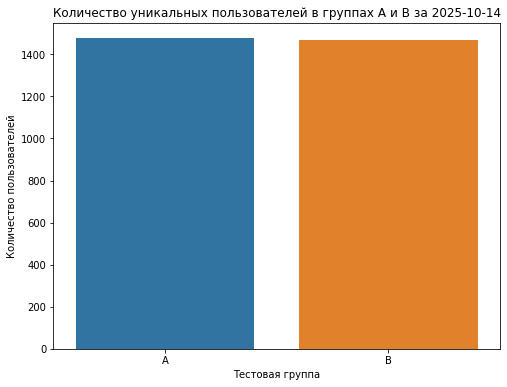

In [20]:


# Рассчитываем процентную разницу
group_a_count = user_counts_first_day['A']
group_b_count = user_counts_first_day['B']

percentage_difference = 100 * abs(group_a_count - group_b_count) / group_a_count

print(f"\nПроцентная разница в количестве пользователей между группами A и B: {percentage_difference:.2f}%")

# Визуализация
plt.figure(figsize=(8, 6))
sns.barplot(x=user_counts_first_day.index, y=user_counts_first_day.values)
plt.title(f'Количество уникальных пользователей в группах A и B за {first_day}')
plt.xlabel('Тестовая группа')
plt.ylabel('Количество пользователей')
plt.show()

#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитайте количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

In [21]:

# Разделяем пользователей на группы
group_a_users = sessions_first_day[sessions_first_day['test_group'] == 'A']['user_id']
group_b_users = sessions_first_day[sessions_first_day['test_group'] == 'B']['user_id']

# Находим пересечение множеств (пользователи, которые есть в обеих группах)
intersecting_users = list(set(group_a_users) & set(group_b_users))

# Считаем количество общих пользователей
num_intersecting_users = len(intersecting_users)

display(num_intersecting_users)


0

#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройства и регионам.

Постройте две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение устройств в группах A и B.


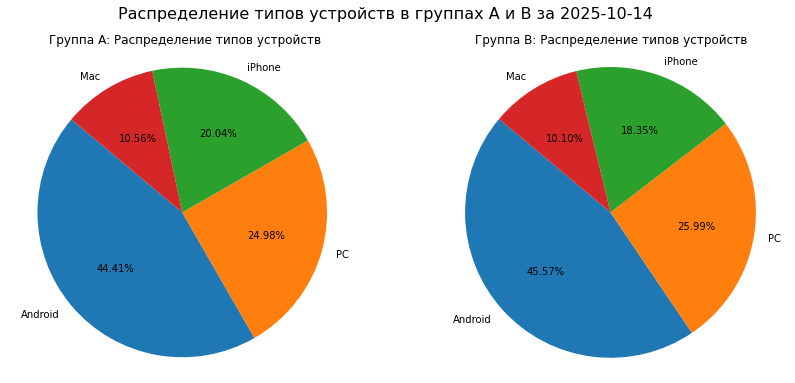

In [22]:
# 0. Убираем дубликаты, оставляем последнюю запись
sessions_first_day = sessions_test_part.drop_duplicates(subset=['user_id'], keep='last')

# 1. Фильтруем данные для каждой группы (A и B)
group_a = sessions_first_day[sessions_first_day['test_group'] == 'A']
group_b = sessions_first_day[sessions_first_day['test_group'] == 'B']

# 2. Считаем количество пользователей для каждого типа устройства в каждой группе
device_counts_a = group_a['device'].value_counts()
device_counts_b = group_b['device'].value_counts()

# 3. Создаем подграфики для круговых диаграмм
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 4. Строим круговую диаграмму для группы A
axes[0].pie(device_counts_a, labels=device_counts_a.index, autopct='%1.2f%%', startangle=140)
axes[0].set_title('Группа A: Распределение типов устройств')
axes[0].axis('equal')  # Обеспечивает круговую форму диаграммы

# 5. Строим круговую диаграмму для группы B
axes[1].pie(device_counts_b, labels=device_counts_b.index, autopct='%1.2f%%', startangle=140)
axes[1].set_title('Группа B: Распределение типов устройств')
axes[1].axis('equal')  # Обеспечивает круговую форму диаграммы

# 6. Добавляем общий заголовок для всей фигуры
fig.suptitle(f'Распределение типов устройств в группах A и B за {first_day}', fontsize=16)

# 7. Отображаем графики
plt.show()

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедитесь, что пользователи равномерно распределены по регионам.

Постройте две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение регионов в группах A и B. Постарайтесь использовать другой тип диаграммы, не тот, что в прошлом задании.


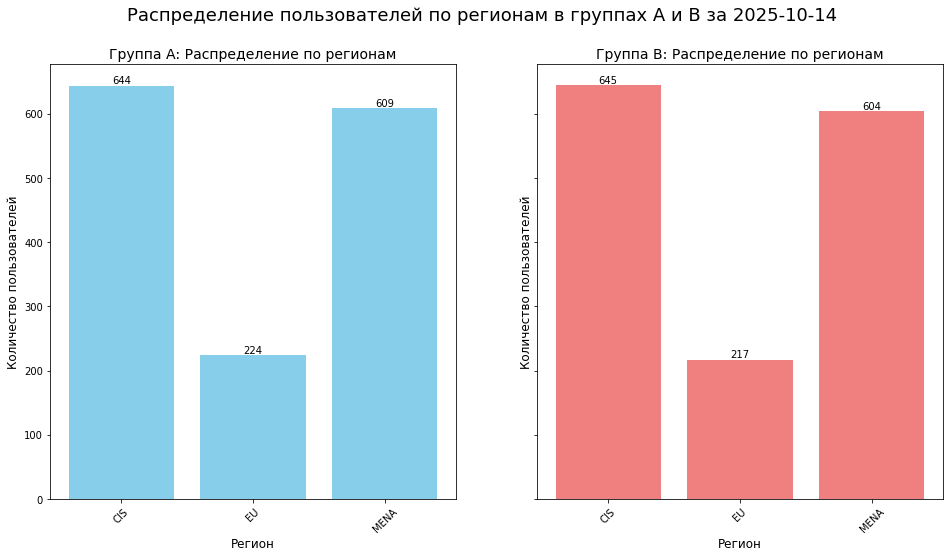

In [23]:

# Считаем количество пользователей для каждого региона в каждой группе
region_counts_a = group_a['region'].value_counts()
region_counts_b = group_b['region'].value_counts()

# Объединяем индексы, чтобы все регионы отображались на обоих графиках 
all_regions = sorted(list(set(region_counts_a.index).union(set(region_counts_b.index))))

# Переиндексируем Series, чтобы включить все регионы (заполняем NaN нулями)
region_counts_a = region_counts_a.reindex(all_regions, fill_value=0)
region_counts_b = region_counts_b.reindex(all_regions, fill_value=0)


# Создаем подграфики для столбчатых диаграмм
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True) # sharey=True для сравнения масштабов

# ---  Строим столбчатую диаграмму для группы A  ---
axes[0].bar(region_counts_a.index, region_counts_a.values, color='skyblue')  # Используем bar вместо pie
axes[0].set_title('Группа A: Распределение по регионам', fontsize=14)
axes[0].set_xlabel('Регион', fontsize=12)
axes[0].set_ylabel('Количество пользователей', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)  

# Добавляем подписи значений над столбцами
for i, v in enumerate(region_counts_a.values):
    axes[0].text(region_counts_a.index[i], v + 3, str(v), ha='center', fontsize=10)


# ---  Строим столбчатую диаграмму для группы B  ---
axes[1].bar(region_counts_b.index, region_counts_b.values, color='lightcoral')  
axes[1].set_title('Группа B: Распределение по регионам', fontsize=14)
axes[1].set_xlabel('Регион', fontsize=12)
axes[1].set_ylabel('Количество пользователей', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

# Добавляем подписи значений над столбцами
for i, v in enumerate(region_counts_b.values):
    axes[1].text(region_counts_b.index[i], v + 3, str(v), ha='center', fontsize=10)

# Добавляем общий заголовок для всей фигуры
fig.suptitle(f'Распределение пользователей по регионам в группах A и B за {first_day}', fontsize=18)

# Отображаем графики
plt.show()


#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста сформулируйте и запишите свои выводы. В выводе обязательно укажите:

- Были ли обнаружено различие в количестве пользователей в двух группах.

- Являются ли выборки независимыми. Было ли обнаружено пересечение пользователей из тестовой и контрольной групп.

- Сохраняется ли равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам.

Сделайте заключение о том, корректно ли проходит A/B-тест или наблюдаются какие-либо нарушения.

Было обнаружено небольшое различие в количестве пользователей. 1477 и 1466 человек, разница составляет 0.74%, это допустимая погрешность.
Выборки являются независимыми, пересечений не обнаружено.
Распределение по устройствам в группах практически равномерное, самая большая разница по типам устройств составляет 1.6% (IPhone в группе А 20.4%, в группе В 18.8%). 
По регионам самые большие различия в 7 единиц (224 в EU в группе А, 217 в EU в группе В). Это составляет примерно 3%, в остальных значениях практически идентичные показатели.

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считайте и сохраните в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [24]:
sessions_test = pd.read_csv('/datasets/sessions_project_test.csv')
sessions_test.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B


In [25]:
sessions_test = pd.read_csv('/datasets/sessions_project_test.csv')

# Создаем столбец good_session (1 если page_counter >= 4, иначе 0)
sessions_test['good_session'] = (sessions_test['page_counter'] >= 4).astype(int)

# Выводим первые строки и распределение good_session
print(sessions_test.head())
print(sessions_test['good_session'].value_counts())

            user_id        session_id session_date     session_start_ts  \
0  6DAE3B3654DA738E  C69249E26E58F6E2   2025-10-26  2025-10-26 18:15:05   
1  0A3FE5D1DD59110A  66D66D7C9F5181B7   2025-10-21  2025-10-21 17:04:53   
2  2041F1D7AA740B88  50DE51D42215E74C   2025-10-23  2025-10-23 17:39:29   
3  43D7585009168086  5763C0C353C22263   2025-10-24  2025-10-24 15:01:57   
4  15AD68B14D62D88C  B1AD09F93C1053BC   2025-10-17  2025-10-17 17:34:39   

  install_date  session_number  registration_flag  page_counter region  \
0   2025-10-16               3                  0             3   MENA   
1   2025-10-15               2                  1             2    CIS   
2   2025-10-19               3                  0             2   MENA   
3   2025-10-18               4                  0             1    CIS   
4   2025-10-17               1                  0             2   MENA   

    device test_group  good_session  
0  Android          A             0  
1  Android          B       

#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и вы будете сравнивать две сопоставимые группы.

- Рассчитайте количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверьте, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы. Используйте статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведите на экран полученное значение p-value и интерпретируйте его.

Формулировка гипотез:

H0 (нулевая) - Количество уникальных дневных сессий не различается между группами A и B: μа = μв

H1 (альтернативная) - Количество уникальных дневных сессий различается между группами A и B: μа <> μв (не равно)

In [26]:
# Группируем по дате и тестовой группе, считаем уникальные сессии
daily_sessions = sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique().reset_index()

# Разделяем данные на две группы
group_a = daily_sessions[daily_sessions['test_group'] == 'A']['session_id']
group_b = daily_sessions[daily_sessions['test_group'] == 'B']['session_id']
print(daily_sessions)


   session_date test_group  session_id
0    2025-10-14          A        1502
1    2025-10-14          B        1628
2    2025-10-15          A        2235
3    2025-10-15          B        2283
4    2025-10-16          A        3280
5    2025-10-16          B        3241
6    2025-10-17          A        4089
7    2025-10-17          B        4054
8    2025-10-18          A        5013
9    2025-10-18          B        5059
10   2025-10-19          A        6535
11   2025-10-19          B        6779
12   2025-10-20          A        5837
13   2025-10-20          B        6089
14   2025-10-21          A        3927
15   2025-10-21          B        3981
16   2025-10-22          A        3083
17   2025-10-22          B        3111
18   2025-10-23          A        2470
19   2025-10-23          B        2548
20   2025-10-24          A        2090
21   2025-10-24          B        2068
22   2025-10-25          A        1897
23   2025-10-25          B        1814
24   2025-10-26          

In [27]:

# Проводим t-тест для независимых выборок
t_stat, p_value = stats.ttest_ind(group_a, group_b, equal_var=False)

print(f"p-value: {p_value:}")

p-value: 0.9382195854082714


P_value (0.9382) > 0.05, соответственно нет статистически значимых различий в количестве уникальных сессий между тестовыми группами A и B. Тест корректный, можно продолжать работу.

#### 4.3. Сравнение доли успешных сессий

Когда вы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

Используйте созданный на первом шаге задания столбец `good_session` и рассчитайте долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразите на экране.

In [28]:
# Рассчитываем долю успешных сессий по группам
grouped = sessions_test.groupby('test_group')['good_session'].agg(['sum', 'count'])
grouped['conversion_rate'] = grouped['sum'] / grouped['count']

# Результаты для групп A и B
conv_rate_a = grouped.loc['A', 'conversion_rate']
conv_rate_b = grouped.loc['B', 'conversion_rate']
diff = conv_rate_b - conv_rate_a

# Выводим результаты
print(f"Доля успешных сессий (Group A): {conv_rate_a:} или {conv_rate_a*100:.2f}%")
print(f"Доля успешных сессий (Group B): {conv_rate_b:} или {conv_rate_b*100:.2f}%")
print(f"Разница (B - A): {diff:.4f} или {diff*100:.2f}%")
print(f"Относительное изменение: {(diff/conv_rate_a)*100:.2f}%")

Доля успешных сессий (Group A): 0.3077233557344958 или 30.77%
Доля успешных сессий (Group B): 0.31828992745867524 или 31.83%
Разница (B - A): 0.0106 или 1.06%
Относительное изменение: 3.43%


Успешные сессии в группе А составили 30.77%, в группе B - 31.83%, что на 1.06% выше в пользу группы В. Относительное увеличение составило 3.43%.

In [29]:
from statsmodels.stats.proportion import proportions_ztest

# Подготовка данных
success_a, total_a = grouped.loc['A', 'sum'], grouped.loc['A', 'count']
success_b, total_b = grouped.loc['B', 'sum'], grouped.loc['B', 'count']

# Z-тест
z_stat, p_value = proportions_ztest(
    count=[success_a, success_b],
    nobs=[total_a, total_b],
    alternative='two-sided'
)

print(f"\nПроверка значимости (Z-тест):")
print(f"Z-статистика: {z_stat:.3f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Вывод: Различия статистически значимы (p < 0.05)")
else:
    print("Вывод: Различия не статистически значимы (p ≥ 0.05)")


Проверка значимости (Z-тест):
Z-статистика: -3.603
p-value: 0.0003
Вывод: Различия статистически значимы (p < 0.05)


P_value (0.0003) < 0.05, разницу можно считать статистически значимой, то есть наблюдается влияние изменений в группе В на метрику.

#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге вы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитайте, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведите на экран полученное значение p-value и свои выводы о статистической значимости. Напомним, что уровень значимости в эксперименте был выбран на уровне 0.05.

Формулировка гипотез: 

H0 (нулевая) - Доля успешных сессий не различается между группами A и B: Pа = Pв 

H1 (альтернативная) - Доля успешных сессий в группе В больше группы А: Pв > Pa 

In [30]:
# Считаем количество успешных сессий и общее количество по группам
success_a = sessions_test[sessions_test['test_group'] == 'A']['good_session'].sum()
total_a = len(sessions_test[sessions_test['test_group'] == 'A'])
success_b = sessions_test[sessions_test['test_group'] == 'B']['good_session'].sum()
total_b = len(sessions_test[sessions_test['test_group'] == 'B'])

# Проводим Z-тест
z_stat, p_value = proportions_ztest(
    count=[success_a, success_b],
    nobs=[total_a, total_b],
    alternative='smaller'  # Односторонний тест
)

# Выводим результаты
print(f"Результаты Z-теста:")
print(f"• Доля успешных сессий (A): {success_a/total_a:.4f} ({success_a}/{total_a})")
print(f"• Доля успешных сессий (B): {success_b/total_b:.4f} ({success_b}/{total_b})")
print(f"• Абсолютная разница: {(success_b/total_b - success_a/total_a):.4f}")
print(f"• Z-статистика: {z_stat:.3f}")
print(f"• p-value: {p_value:.4f}")

# Интерпретация
alpha = 0.05
if p_value < alpha:
    print("\nВывод: Различия статистически значимы (p < 0.05).")
else:
    print("\nВывод: Различия не статистически значимы (p ≥ 0.05).")

Результаты Z-теста:
• Доля успешных сессий (A): 0.3077 (15248/49551)
• Доля успешных сессий (B): 0.3183 (16059/50454)
• Абсолютная разница: 0.0106
• Z-статистика: -3.603
• p-value: 0.0002

Вывод: Различия статистически значимы (p < 0.05).


P_value (0.0002) < 0.05, соответственно это статистически значимые различия, отвергаем нулевую гипотезу и принимаем альтернативную. Величина Z отрицательная, значит доля в группе В больше.

#### 4.5. Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируйте и запишите свои выводы для команды разработки приложения. В выводе обязательно укажите:

- Характеристики проведённого эксперимента, количество задействованных пользователей и длительность эксперимента.

- Повлияло ли внедрение нового алгоритма рекомендаций на рост ключевой метрики и как.

- Каким получилось значение p-value для оценки статистической значимости выявленного эффекта.

- Стоит ли внедрять новоовведение в приложение.

После изучения датафреймов подготовили две группы для проведения теста на 1477 и 1466 пользователей, разница составила 0.74%. Пользователи были уникальными, не пересекались в группах А и В. За 14.10.2025 Распределение по устройствам в группах практически равномерное, самая большая разница по типам устройств составляет 1.6% (IPhone в группе А 20.4%, в группе В 18.8%). 
По регионам самые большие различия в 7 единиц (224 в EU в группе А, 217 в EU в группе В). Это составляет примерно 3%, в остальных значениях практически идентичные показатели.

После этого считали успешные сессии: в группе А они составили 30.77%, в группе B - 31.83%, что на 1.06% выше в пользу группы В. Относительное увеличение составило 3.43%.

Величина P_value (0.0002) оказалось меньше уровня значимости (0.05), соответственно это статистически значимые различия, отвергаем нулевую гипотезу и принимаем альтернативную. Величина Z отрицательная (-3.603), значит доля в группе В больше. Можно рекомендовать внедрить нововведение.